In [2]:
import os

import numpy as np
#import opencv

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
#from torchsummary import summary
from tqdm import tqdm

In [3]:
data_path = r'/kaggle/input/labeled-chest-xray-images/chest_xray'

In [4]:
class_name = ['NORMAL', 'PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [5]:
print("Number of training images in Normal {}".format(len(files_list_normal_train)))
print("Number of training images in Pneumonia {}".format(len(files_list_pneu_train)))
print("Number of test images in Normal {}".format(len(files_list_normal_test)))
print("Number of test images in Pneumonia {}".format(len(files_list_pneu_test)))

Number of training images in Normal 1349
Number of training images in Pneumonia 3883
Number of test images in Normal 234
Number of test images in Pneumonia 390


(1287, 1696)


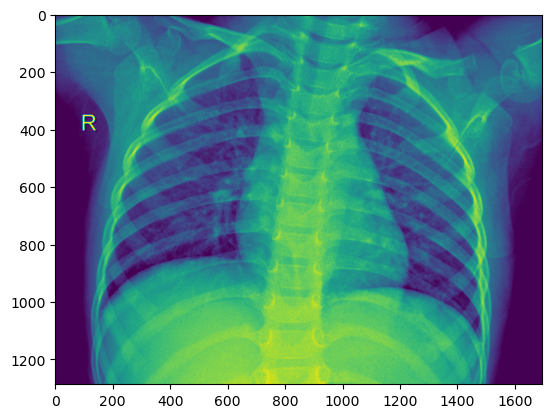

In [5]:
rand_img_no = np.random.randint(0, len(files_list_normal_train))
img = data_path +'/train/NORMAL/'+ files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(581, 952)


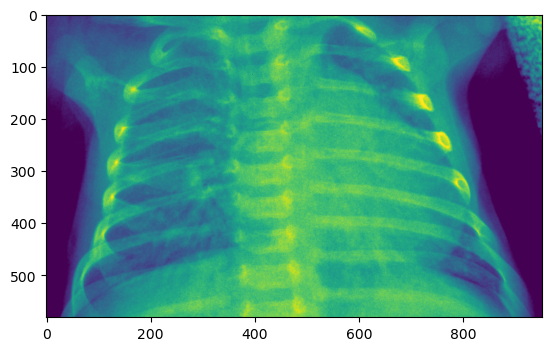

In [6]:
rand_img_no = np.random.randint(0, len(files_list_pneu_train))
img = data_path +'/train/PNEUMONIA/'+ files_list_pneu_train[rand_img_no]
print(plt.imread(img).shape)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)


train_loader =DataLoader(train_data,
                         batch_size= 16,
                         shuffle= True,
                         pin_memory= True)

test_loader = DataLoader(test_data,
                         batch_size= 1,
                         shuffle= False,
                         pin_memory= True)


class_names = train_data.classes

print(class_names)
print(f'Number of train images : {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']

Number of train images : 5232

Number of test images: 624


In [8]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         #input block
#         self.conblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3),
#                       padding=0, bias=False),
#                       nn.ReLU(),
#         )
#         self.pool11 = nn.MaxPool2d(2,2)

#         #convolution block
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
#             nn.ReLU(),
#         )

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
        padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(4)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
        padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(16)
        )
        # TRANSITION BLOCK
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #nn.BatchNorm2d(10),
        nn.ReLU()
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        #nn.BatchNorm2d(32),
        nn.ReLU(),
        )
        self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        #nn.BatchNorm2d(32),
        nn.ReLU()
        )
        self.convblock9 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
        nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        nn.ReLU(),
        #nn.BatchNorm2d(16),
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
        )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))

model = Net().to(device)

Available processor cuda


In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        #get data
        data, target = data.to(device), target.to(device)

        #intialization of gradient
        optimizer.zero_grad()

        # prediction on data
        y_pred =model(data)

        #calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        #backpropagation
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim = True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f'loss={loss.item()} batch_id={batch_idx} accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss:{:.4f}, accuracy:{}/{}({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100.*correct / len(test_loader.dataset)))
    test_acc.append(100. * correct/len(test_loader.dataset))

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print('EPOCH:', epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


loss=0.6931391358375549 batch_id=326 accuracy=79.97: 100%|██████████| 327/327 [04:26<00:00,  1.23it/s]


current Learning Rate:  0.01



Test set: Average loss:0.6931, accuracy:391/624(62.66%)



EPOCH: 1


loss=0.6930923461914062 batch_id=326 accuracy=74.18: 100%|██████████| 327/327 [03:47<00:00,  1.44it/s]


current Learning Rate:  0.01



Test set: Average loss:0.6931, accuracy:390/624(62.50%)



EPOCH: 2


loss=0.6927277445793152 batch_id=326 accuracy=74.22: 100%|██████████| 327/327 [03:59<00:00,  1.36it/s]


current Learning Rate:  0.01



Test set: Average loss:0.6929, accuracy:390/624(62.50%)



EPOCH: 3


loss=0.3642142117023468 batch_id=326 accuracy=80.22: 100%|██████████| 327/327 [03:22<00:00,  1.62it/s]  


current Learning Rate:  0.01



Test set: Average loss:0.7032, accuracy:413/624(66.19%)



EPOCH: 4


loss=0.22752058506011963 batch_id=326 accuracy=90.92: 100%|██████████| 327/327 [03:15<00:00,  1.68it/s]  


current Learning Rate:  0.01



Test set: Average loss:0.5084, accuracy:521/624(83.49%)



EPOCH: 5


loss=0.3277982771396637 batch_id=326 accuracy=92.64: 100%|██████████| 327/327 [03:13<00:00,  1.69it/s]   


current Learning Rate:  0.005



Test set: Average loss:0.5366, accuracy:526/624(84.29%)



EPOCH: 6


loss=0.15397171676158905 batch_id=326 accuracy=93.69: 100%|██████████| 327/327 [03:14<00:00,  1.68it/s] 


current Learning Rate:  0.005



Test set: Average loss:0.7228, accuracy:495/624(79.33%)



EPOCH: 7


loss=0.06279353052377701 batch_id=326 accuracy=94.30: 100%|██████████| 327/327 [03:13<00:00,  1.69it/s]  


current Learning Rate:  0.005



Test set: Average loss:0.6616, accuracy:510/624(81.73%)



EPOCH: 8


loss=0.06649801135063171 batch_id=326 accuracy=94.44: 100%|██████████| 327/327 [03:25<00:00,  1.59it/s] 


current Learning Rate:  0.005



Test set: Average loss:0.7072, accuracy:520/624(83.33%)



EPOCH: 9


loss=0.02089795097708702 batch_id=326 accuracy=94.65: 100%|██████████| 327/327 [03:25<00:00,  1.59it/s] 


current Learning Rate:  0.005



Test set: Average loss:0.7956, accuracy:497/624(79.65%)



EPOCH: 10


loss=0.08899466693401337 batch_id=326 accuracy=94.67: 100%|██████████| 327/327 [03:27<00:00,  1.58it/s]  


current Learning Rate:  0.005



Test set: Average loss:0.4376, accuracy:535/624(85.74%)



EPOCH: 11


loss=0.15551336109638214 batch_id=326 accuracy=95.07: 100%|██████████| 327/327 [03:23<00:00,  1.60it/s] 


current Learning Rate:  0.0025



Test set: Average loss:0.4693, accuracy:521/624(83.49%)



EPOCH: 12


loss=0.01641697809100151 batch_id=326 accuracy=95.45: 100%|██████████| 327/327 [03:36<00:00,  1.51it/s]  


current Learning Rate:  0.0025



Test set: Average loss:0.5237, accuracy:511/624(81.89%)



EPOCH: 13


loss=0.1722748875617981 batch_id=326 accuracy=95.66: 100%|██████████| 327/327 [03:29<00:00,  1.56it/s]   


current Learning Rate:  0.0025



Test set: Average loss:0.5991, accuracy:509/624(81.57%)



EPOCH: 14


loss=0.29580768942832947 batch_id=326 accuracy=95.66: 100%|██████████| 327/327 [03:23<00:00,  1.60it/s]  


current Learning Rate:  0.0025



Test set: Average loss:0.5487, accuracy:511/624(81.89%)




Text(0.5, 1.0, 'Test Accuracy')

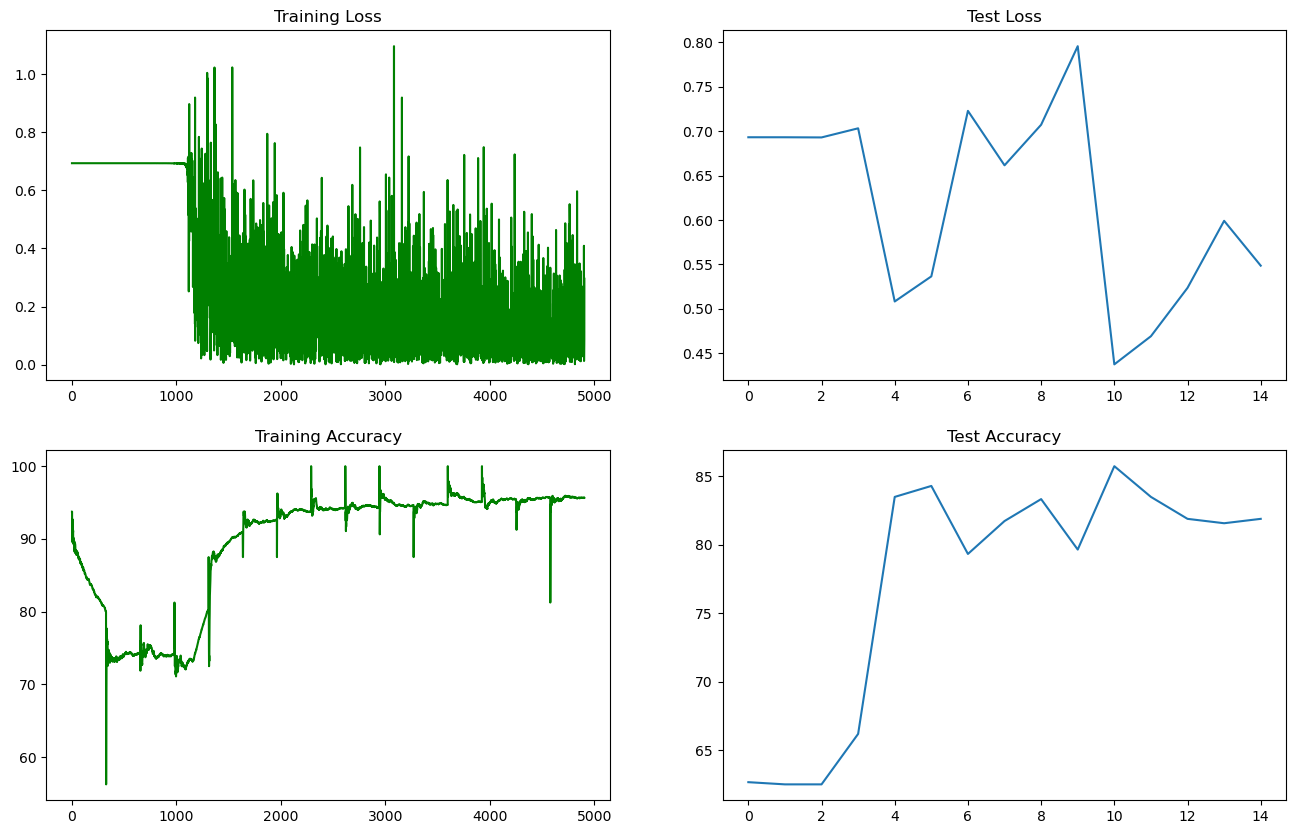

In [15]:
train_losses1 =  [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 =  [i for i in test_acc]


fig, axs = plt.subplots(2,2, figsize= (16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

### 2nd variation of model

Adding more data augmentation to help improve model


In [9]:
train_transform2 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ])
test_transform2 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ])

In [10]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform2)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform2)


train_loader2 =DataLoader(train_data,
                         batch_size= 16,
                         shuffle= True,
                         pin_memory= True)

test_loader2 = DataLoader(test_data,
                         batch_size= 1,
                         shuffle= False,
                         pin_memory= True)


class_names = train_data.classes

print(class_names)
print(f'Number of train images : {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images : 5232
Number of test images: 624


In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print('EPOCH:', epoch)
    train(model, device, train_loader2, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader2)

EPOCH: 0


loss=0.6929576396942139 batch_id=326 accuracy=74.16: 100%|██████████| 327/327 [02:37<00:00,  2.08it/s]


current Learning Rate:  0.01

Test set: Average loss:0.6930, accuracy:390/624(62.50%)

EPOCH: 1


loss=0.5207942128181458 batch_id=326 accuracy=74.60: 100%|██████████| 327/327 [01:53<00:00,  2.89it/s] 


current Learning Rate:  0.01

Test set: Average loss:0.6306, accuracy:390/624(62.50%)

EPOCH: 2


loss=0.2280273586511612 batch_id=326 accuracy=88.44: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s]  


current Learning Rate:  0.01

Test set: Average loss:0.7375, accuracy:513/624(82.21%)

EPOCH: 3


loss=0.28150737285614014 batch_id=326 accuracy=91.53: 100%|██████████| 327/327 [01:50<00:00,  2.97it/s] 


current Learning Rate:  0.01

Test set: Average loss:0.8294, accuracy:498/624(79.81%)

EPOCH: 4


loss=0.26389944553375244 batch_id=326 accuracy=92.87: 100%|██████████| 327/327 [01:50<00:00,  2.96it/s] 


current Learning Rate:  0.01

Test set: Average loss:0.5096, accuracy:505/624(80.93%)

EPOCH: 5


loss=0.09704868495464325 batch_id=326 accuracy=93.83: 100%|██████████| 327/327 [01:54<00:00,  2.86it/s] 


current Learning Rate:  0.005

Test set: Average loss:0.5202, accuracy:506/624(81.09%)

EPOCH: 6


loss=0.1263331025838852 batch_id=326 accuracy=93.85: 100%|██████████| 327/327 [01:53<00:00,  2.89it/s]   


current Learning Rate:  0.005

Test set: Average loss:0.4628, accuracy:508/624(81.41%)

EPOCH: 7


loss=0.29843267798423767 batch_id=326 accuracy=94.21: 100%|██████████| 327/327 [01:52<00:00,  2.90it/s]  


current Learning Rate:  0.005

Test set: Average loss:0.4961, accuracy:521/624(83.49%)

EPOCH: 8


loss=0.18244004249572754 batch_id=326 accuracy=94.38: 100%|██████████| 327/327 [01:50<00:00,  2.95it/s] 


current Learning Rate:  0.005

Test set: Average loss:0.7092, accuracy:512/624(82.05%)

EPOCH: 9


loss=0.11493092030286789 batch_id=326 accuracy=94.69: 100%|██████████| 327/327 [01:53<00:00,  2.89it/s]  


current Learning Rate:  0.005

Test set: Average loss:0.4577, accuracy:509/624(81.57%)

EPOCH: 10


loss=0.17960268259048462 batch_id=326 accuracy=94.95: 100%|██████████| 327/327 [01:52<00:00,  2.92it/s]  


current Learning Rate:  0.005

Test set: Average loss:0.5013, accuracy:524/624(83.97%)

EPOCH: 11


loss=0.08807412534952164 batch_id=326 accuracy=94.72: 100%|██████████| 327/327 [01:51<00:00,  2.92it/s]  


current Learning Rate:  0.0025

Test set: Average loss:0.7415, accuracy:507/624(81.25%)

EPOCH: 12


loss=0.4605306386947632 batch_id=326 accuracy=95.47: 100%|██████████| 327/327 [01:50<00:00,  2.96it/s]   


current Learning Rate:  0.0025

Test set: Average loss:0.7807, accuracy:505/624(80.93%)

EPOCH: 13


loss=0.025909945368766785 batch_id=326 accuracy=95.55: 100%|██████████| 327/327 [01:49<00:00,  2.98it/s] 


current Learning Rate:  0.0025

Test set: Average loss:0.5160, accuracy:524/624(83.97%)

EPOCH: 14


loss=0.05924132466316223 batch_id=326 accuracy=95.32: 100%|██████████| 327/327 [01:54<00:00,  2.86it/s]  


current Learning Rate:  0.0025

Test set: Average loss:0.3737, accuracy:542/624(86.86%)



Text(0.5, 1.0, 'Test Accuracy')

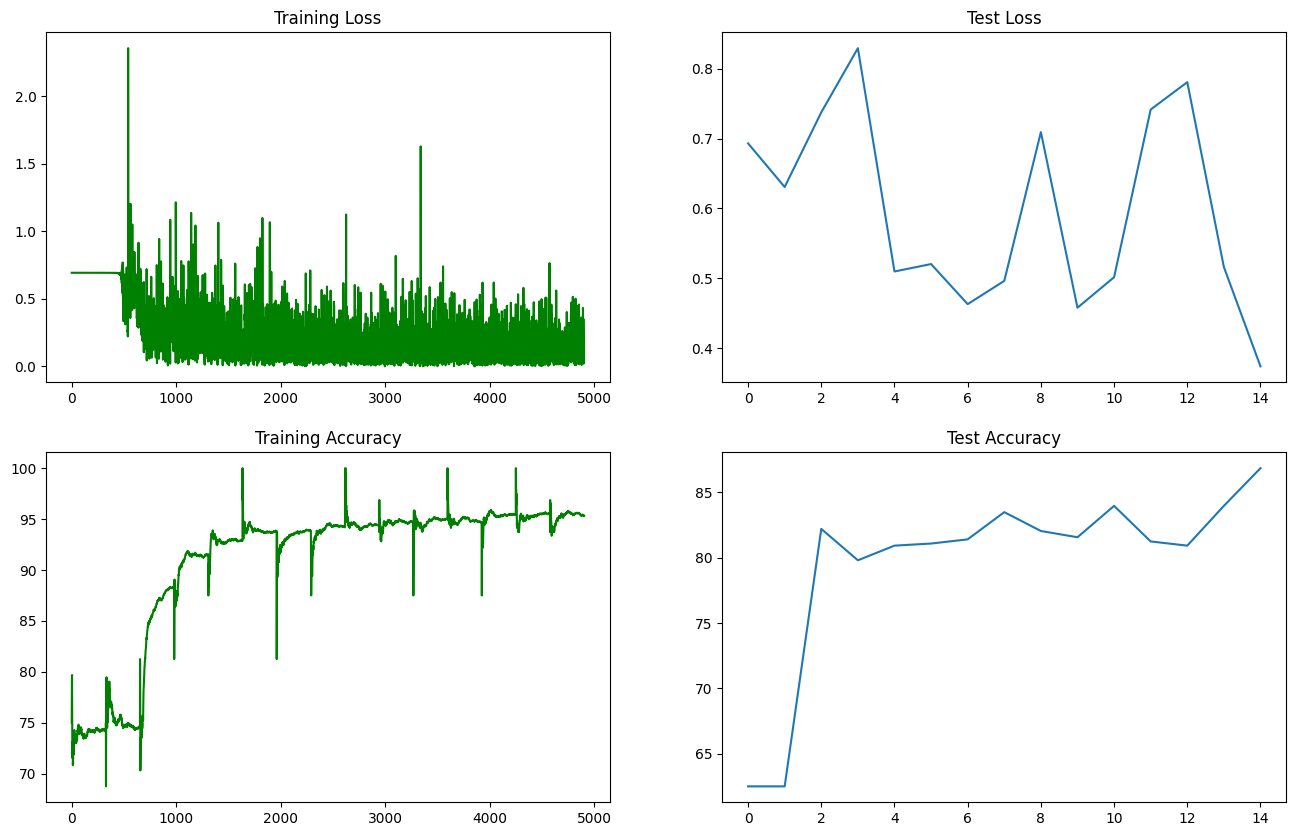

In [12]:
train_losses2 =  [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc2 = [i for i in train_acc]
test_losses2 = [i for i in test_losses]
test_acc2 =  [i for i in test_acc]


fig, axs = plt.subplots(2,2, figsize= (16,10))
axs[0, 0].plot(train_losses2,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc2,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses2)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc2)
axs[1, 1].set_title("Test Accuracy")